# Digital Twin Fairways
WIP to use the OpenTNSim engine

In [1]:
import datetime
import json
import logging
import time
import functools

import dtv_backend.berthing

# the simpy processes and objects
import dtv_backend.compat

# library to load the fairway information network
import dtv_backend.fis
import dtv_backend.network
import dtv_backend.network.network_utilities
import dtv_backend.postprocessing
import dtv_backend.simple
import dtv_backend.simulate
import geojson
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely
import simpy
import numpy as np
from networkx.readwrite import json_graph

# opentnsim import
from opentnsim import core
import opentnsim.energy

import plotly.express as px
import matplotlib.pyplot as plt


# reload for debugging purposes
%load_ext autoreload
%autoreload 2
logging.basicConfig()

logger = logging.getLogger("notebook")

opentnsim.energy.logger.setLevel(logging.INFO)



### Input
You can define your input in a json configuration file. The relevant parts are sites, fleet and climate.

In [2]:
# example input
with open("../../dtv_backend/tests/user/2022-10-22-config.json") as f:
    config = geojson.load(f)

### Simulate with ``v3_run``

In [3]:
def v3_dtv_backend_simulate(config):
    result = dtv_backend.simulate.v3_run(config)
    env = result['env']
    logbook = result['operator'].logbook
    log_df = pd.DataFrame(logbook)
    log_json = dtv_backend.postprocessing.log2json(log_df)
    
    response = {
        "log": log_json,
        "config": config,
        "env": {
            "epoch": env.epoch.timestamp(),
            "epoch_iso": env.epoch.isoformat(),
            "now": env.epoch,
            "now_iso": datetime.datetime.fromtimestamp(env.now).isoformat(),
        },
    }
    return response
    

<AxesSubplot:>

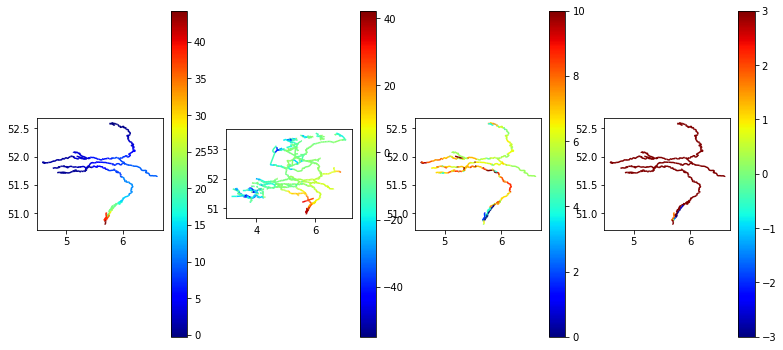

In [4]:
fig, axes = plt.subplots(ncols=4, figsize=(13, 6))
quantity_df = gpd.GeoDataFrame.from_features(config['quantities']['bathymetry'])
quantity_df['waterdepth'] = quantity_df['waterlevel'] - quantity_df['nap_p5']
quantity_df['waterdepth_ok'] =  ~np.isnan(quantity_df['waterdepth']) & (quantity_df['waterdepth'] > 3.5)
quantity_df.plot('waterlevel', legend=True, cmap='jet', ax=axes[0])
quantity_df.plot('nap_p5', legend=True, cmap='jet', ax=axes[1])
quantity_df.plot('waterdepth', legend=True, cmap='jet', ax=axes[2], vmin=0, vmax=10)
quantity_df.plot('waterdepth', legend=True, cmap='jet', ax=axes[3], vmin=-3, vmax=3) 


In [5]:
result = dtv_backend.simulate.v3_run(config)
env = result['env']
logbook = result['operator'].logbook
log_df = pd.DataFrame(logbook)


/Users/baart_f/src/digitaltwin-waterway/dtv_backend/dtv_backend/fis.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



{"geometry": {"coordinates": [[4.013855, 51.957121], [4.013855, 51.957121], [4.005896, 51.960652], [3.999617, 51.960532], [3.999617, 51.960532]], "type": "LineString"}, "id": 0, "properties": {"Beam 10% percentile [m]": 10.6, "Beam 50% percentile [m]": 11.45, "Beam 90% percentile [m]": 11.45, "Beam [m]": 11.4, "CEMT-class": "Va", "Description (Dutch)": "Groot Rijnschip", "Description (English)": "Large Rhine vessel", "Draught average [m]": 3.14, "Draught empty [m]": 1.4, "Draught loaded [m]": 3.5, "Engine power maximum [kW]": "1100", "Height average [m]": 6.21, "Length 10% percentile [m]": 93, "Length 50% percentile [m]": 110, "Length 90% percentile [m]": 110, "Length [m]": 110, "Load Weight average [ton]": 2286, "Load weight maximum [ton]": 2689, "RWS-class": "M8", "Velocity [m/s]": "4", "Vessel type": "Motorvessel", "capacity": 1400, "count": 1, "image": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRvKRniAxUXUWzmByw7CRFYD5fTqOtFTDVkw&usqp=CAU", "name": "Large Rhine vessel"

# Look at the energy log

In [6]:
# # append all energy logs together

def row2energy_df(row):
    """create an energy dataframe for a sailing message"""
    energy_df_i = pd.DataFrame(row['Meta']['energy_profile'])
    return energy_df_i
    
sailing_stop_idx = np.logical_and(
    log_df['Message'] == 'Sailing',
    log_df['Meta'].apply(lambda x: x['state']) == 'STOP'
)

stop_messages = log_df[sailing_stop_idx]
energy_df = pd.concat(stop_messages.apply(
    row2energy_df, 
    axis=1
).values).reset_index(drop=True)
energy_gdf = gpd.GeoDataFrame(energy_df)

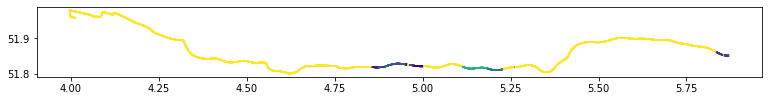

In [7]:
fig, ax = plt.subplots(figsize=(13, 8))
energy_gdf.plot('power', ax=ax)

# 
energy_gdf['source'] = energy_gdf['e'].apply(lambda e: e[0])
energy_gdf['target'] = energy_gdf['e'].apply(lambda e: e[1])
energy_gdf.drop(columns=['e', 'edge']).to_file('/Users/baart_f/Downloads/energy.geojson')

In [8]:
gdf = gpd.GeoDataFrame.from_features(resp['log'])
fig = px.timeline(
    gdf, x_start="Start", x_end="Stop", y="Name", color="Actor", opacity=0.3
)

fig.update_yaxes(autorange="reversed")


NameError: name 'resp' is not defined

In [ ]:
log_df.query('Message == "Cycle"').shape[0] / 2

In [ ]:
log_df.iloc[-1].Timestamp - log_df.iloc[0].Timestamp

In [ ]:
plt.hist(energy_df.v);

In [ ]:
log_df.query("Message=='Sailing'")

In [ ]:
energy_gdf['fuel'].sum()